<div class="alert alert-block alert-info">
    <h2>Phase1 Using Machine learning models to predict the NBA Players' salary with on court and off court data</h2>
</div>


<div class="alert alert-block alert-info">
    <h2>Load Data</h2>
</div>


In [7]:
import matplotlib
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
# 用来将分类变量比如球员位置等转换成独热编码 来送入机器学习算法
# standardScaler 用来讲数值特征组标准化. 将数据转换为相同均值 相同标准差来表达同一尺度, 有利于模型稳定
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# 针对不同列应用不同的转换器 比如如果是数值列做standardScaler, 如果是分类特征做OneHotEncoder
from sklearn.compose import ColumnTransformer
# 将预处理数据比如Transformer和最终的模型合在一起形成一个对象. 这样对数据的预处理和模型调用一起搞了
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
# 数据集切分 将原始数据随机划分为训练集和测试集 通常按70/30 80/20比例.
from sklearn.model_selection import train_test_split
# 模型评估指标 MSE 预测值和真实值误差的二次方平均. r^2衡量模型对数据的拟合优度. 越接近1表示模型拟合越好
# MAE 平均绝对误差 预测误差的绝对值平均 对异常值不如MSE敏感
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# 用于填充缺失值NaN
from sklearn.impute import SimpleImputer
from scipy import stats
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_validate



# Load data from the csvs
player_stats = pd.read_csv('data/NBA Player Stats(1950 - 2022).csv')
salaries = pd.read_csv('data/NBA Salaries(1990-2023).csv')

<div class="alert alert-block alert-info">
    <h2>Data Clean</h2>
</div>


In [9]:

# Clean player names and standardize formatting in both datasets
player_stats['Player_clean'] = player_stats['Player'].str.lower().str.strip()
salaries['playerName_clean'] = salaries['playerName'].str.lower().str.strip()

# 把赛季字段存放到新的clean列里. 改成int
player_stats['Season_clean'] = player_stats['Season'].astype(int)
salaries['seasonStartYear_clean'] = salaries['seasonStartYear'].astype(int)

# Perform a full outer join to merge both datasets on player names and seasons/years
merged_data = pd.merge(
    player_stats,
    salaries,
    # 指定左表和右表join的特征
    left_on=['Player_clean', 'Season_clean'],
    right_on=['playerName_clean', 'seasonStartYear_clean'],
    # 用外连接
    how='outer'
)

print(merged_data)

df = merged_data

# Drop the Unnamed columns since they are just the id columns
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0_x', 'Unnamed: 0_y'], errors='ignore')\

# Columns and their descriptions

# Index: A sequential number assigned to each row, starting from 1.
# Season: The starting year of the NBA season.
# Player: Player's name.
# Pos: Player's position (e.g., G for Guard, F for Forward, C for Center).
# Age: Player's age during the season.
# Tm: Team abbreviation (e.g., LAL for Los Angeles Lakers).
# G: Games played by the player during the season.
# GS: Games started by the player during the season.
# MP: Total minutes played by the player.
# FG: Field goals made (total baskets scored except free throws).
# FGA: Field goals attempted.
# FG%: Field goal percentage (FG / FGA).
# 3P: 3-point shots made.
# 3PA: 3-point shots attempted.
# 3P%: 3-point shooting percentage (3P / 3PA).
# 2P: 2-point shots made.
# 2PA: 2-point shots attempted.
# 2P%: 2-point shooting percentage (2P / 2PA).
# eFG%: Effective field goal percentage, accounting for the added value of 3-pointers.

# FT: Free throws made.
# FTA: Free throws attempted.
# FT%: Free throw percentage (FT / FTA).

# ORB: Offensive rebounds.
# DRB: Defensive rebounds.
# TRB: Total rebounds (ORB + DRB).
# AST: Assists made by the player.
# STL: Steals made by the player.
# BLK: Blocks made by the player.
# TOV: Turnovers (times the player lost possession).
# PF: Personal fouls committed.
# PTS: Total points scored by the player during the season.

# Player_clean: A cleaned version of the Player column (lowercase, stripped of spaces).
# Season_clean: A cleaned version of the Season column.
# playerName: Player's name from the salaries dataset.
# seasonStartYear: Starting year of the NBA season from the salaries dataset.
# salary: Player's salary for the season.
# inflationAdjSalary: Player's salary adjusted for inflation.
# playerName_clean: A cleaned version of the playerName column.
# seasonStartYear_clean: A cleaned version of the seasonStartYear column.

# 把inflationAdjSalary drop的原因是已经有salary这个feature 了 salary更relevant. 放一起会有多重共线的可能
df.drop(columns=['inflationAdjSalary'], inplace=True)
print(df.columns)


       Unnamed: 0.1  Unnamed: 0_x  Season          Player Pos   Age   Tm  \
0            8385.0         117.0  1986.0      A.C. Green  PF  22.0  LAL   
1            8785.0         122.0  1987.0      A.C. Green  PF  23.0  LAL   
2            9188.0         131.0  1988.0      A.C. Green  PF  24.0  LAL   
3            9638.0         139.0  1989.0      A.C. Green  PF  25.0  LAL   
4           10101.0         147.0  1990.0      A.C. Green  PF  26.0  LAL   
...             ...           ...     ...             ...  ..   ...  ...   
33069       17622.0         453.0  2004.0  Željko Rebrača   C  31.0  TOT   
33070       17623.0         454.0  2004.0  Željko Rebrača   C  31.0  DET   
33071       17624.0         455.0  2004.0  Željko Rebrača   C  31.0  ATL   
33072       18223.0         447.0  2005.0  Željko Rebrača   C  32.0  LAC   
33073       18818.0         434.0  2006.0  Željko Rebrača   C  33.0  LAC   

          G    GS      MP  ...     PTS    Player_clean  Season_clean  \
0      82.0   1

In [10]:
#Missing and Null value analysis
missing_summary = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percent': (df.isnull().sum() / len(df)) * 100
}).sort_values(by='Missing Percent', ascending=False)
print(missing_summary)

                       Missing Count  Missing Percent
seasonStartYear                14826        44.826752
playerName                     14826        44.826752
salary                         14826        44.826752
playerName_clean               14826        44.826752
seasonStartYear_clean          14826        44.826752
3P%                            13866        41.924170
GS                             10721        32.415190
3PA                            10074        30.458971
3P                             10074        30.458971
TOV                             9356        28.288081
BLK                             8204        24.804983
ORB                             8204        24.804983
STL                             8204        24.804983
DRB                             8204        24.804983
FT%                             5439        16.444942
MP                              4805        14.528028
TRB                             4616        13.956582
2P%                         

In [12]:
# DATA CLEANING:
#
# Drop irrelevant columns
# These columns were used for merging and are duplicates of existing info.
df = df.drop(columns=['Player_clean', 'Season_clean', 'playerName_clean', 'seasonStartYear_clean'], errors='ignore')

# Drop columns with more than 80% missing values --> they dont tell us much about player stats and they aren't helpful in predicting salary
threshold = 0.8
df = df.loc[:, df.isnull().mean() < threshold]

In [13]:
# Clean salary column to just have numbers
# Remove dollar signs and commas & convert to numeric
df['salary'] = df['salary'].replace(r'[\$,]', '', regex=True).astype(float)

# Handle missing values for salary
# Impute missing salaries using the median salary grouped by Team and Season Year --> this is pretty unbiased
df['salary'] = df.groupby(['Tm', 'seasonStartYear'])['salary'].transform(lambda x: x.fillna(x.median()))

# If any salary values are still missing, fill with 0
df['salary'] = df['salary'].fillna(0)

# Drop rows where season Year or Player is missing --> this information is essential in predicting salaries since withouth the player and their season info are important
df = df.dropna(subset=['Player', 'seasonStartYear'])

# Impute missing values for positions and teams with the mode / Unknown placeholder.
df['Pos'] = df['Pos'].fillna(df['Pos'].mode()[0])  # Fill with the most frequent value
df['Tm'] = df['Tm'].fillna('Unknown')  # Assign 'Unknown' to missing team data

# Impute the missing values for numerical columns by using the median --> median is not as affected by extreme values as mean & so this ensures that the imputed values are more representative of the typical data
num_columns = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
               '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
               'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
for col in num_columns:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

df.isnull().sum()

/tmp/ipython-input-13-3596770353.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pos'] = df['Pos'].fillna(df['Pos'].mode()[0])  # Fill with the most frequent value
/tmp/ipython-input-13-3596770353.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tm'] = df['Tm'].fillna('Unknown')  # Assign 'Unknown' to missing team data
/tmp/ipython-input-13-3596770353.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Season             0
Player             0
Pos                0
Age                0
Tm                 0
G                  0
GS                 0
MP                 0
FG                 0
FGA                0
FG%                0
3P                 0
3PA                0
3P%                0
2P                 0
2PA                0
2P%                0
eFG%               0
FT                 0
FTA                0
FT%                0
ORB                0
DRB                0
TRB                0
AST                0
STL                0
BLK                0
TOV                0
PF                 0
PTS                0
playerName         0
seasonStartYear    0
salary             0
dtype: int64

In [14]:
# CHECK FOR OUTLIERS
# Numerical columns to check for outliers
columns_to_check = [
    'PTS', 'AST', 'TRB', 'STL', 'BLK', 'MP', 'G', 'GS', 'FG', 'FGA', 'FG%',
    '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
    'DRB', 'TOV', 'PF', 'Age'
]

outliers_indices = set()

for column in columns_to_check:
    # Calculate Z-scores z score判断数值是不是outliers
    # 计算非空的z score
    z_scores = stats.zscore(df[column].dropna())

    # Identify outliers (Z-score > 4 or < -4) --> we use threshold of 4 for more strict outlier checking
    column_outliers = df[np.abs(z_scores) > 4].index
    # 找出z大于4的行索引放入outliers中
    outliers_indices.update(column_outliers)

# Calculate total number of unique outliers and percentage
total_outliers = len(outliers_indices)
percentage_outliers = (total_outliers / len(df)) * 100

print(f"\nTotal number of unique outliers: {total_outliers}")
print(f"Percentage of data containing outliers: {percentage_outliers:.2f}%")

# Remove the outliers from the dataset
df = df.drop(outliers_indices, axis=0)
print(f"\nData size after removing the outliers: {len(df)}")

df.columns


Total number of unique outliers: 832
Percentage of data containing outliers: 5.97%

Data size after removing the outliers: 13112


Index(['Season', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'playerName', 'seasonStartYear', 'salary'],
      dtype='object')

In [ ]:
from scipy import stats

# CHECK FOR OUTLIERS

# Numerical columns to check for outliers
columns_to_check = [
    'PTS', 'AST', 'TRB', 'STL', 'BLK', 'MP', 'G', 'GS', 'FG', 'FGA', 'FG%',
    '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
    'DRB', 'TOV', 'PF', 'Age'
]

outliers_indices = set()

for column in columns_to_check:
    # Calculate Z-scores
    z_scores = stats.zscore(df[column].dropna())

    # Identify outliers (Z-score > 4 or < -4) --> we use threshold of 4 for more strict outlier checking
    column_outliers = df[np.abs(z_scores) > 4].index
    outliers_indices.update(column_outliers)


# Calculate total number of unique outliers and percentage
total_outliers = len(outliers_indices)
percentage_outliers = (total_outliers / len(df)) * 100

print(f"\nTotal number of unique outliers: {total_outliers}")
print(f"Percentage of data containing outliers: {percentage_outliers:.2f}%")



Total number of unique outliers: 832
Percentage of data containing outliers: 5.97%


In [ ]:
# Remove the outliers from the dataset
df = df.drop(outliers_indices, axis=0)
print(f"\nData size after removing the outliers: {len(df)}")



Data size after removing the outliers: 13112


In [ ]:
df.columns

Index(['Season', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'playerName', 'seasonStartYear', 'salary'],
      dtype='object')

<div class="alert alert-block alert-info">
    <h2>Feature Engineering</h2>
</div>


In [15]:
# Convert relevant columns to integers for mathematical operations
int_columns = ['PTS', 'TRB', 'AST', 'STL', 'BLK', 'FGA', 'FG', 'FTA', 'FT', 'GS', 'G']
for col in int_columns:
    df[col] = df[col].fillna(0).astype(int)

# Calculate Weighted Efficiency (WEFF) using a formula that evaluates overall player performance:
# - Rewards positive contributions such as points scored (PTS), assists (AST), rebounds (TRB), steals (STL), and blocks (BLK).
# - Penalizes inefficiencies like missed field goals (FGA - FG) and missed free throws (FTA - FT).
# - Subtracts turnovers (TOV) as a negative contribution.
# - Normalizes the result by dividing the total by the number of games played (G).

# 为每一个球员设置一个新的综合表现水平的feature
df['WEFF'] = ((2 * df['PTS'] + 1.5 * df['AST'] + 1.2 * df['TRB'] +
               df['STL'] + df['BLK'] - 0.5 * (df['FGA'] - df['FG']) -
               0.5 * (df['FTA'] - df['FT']) - df['TOV']) / df['G'])

# Handle infinite and missing values
df['WEFF'] = df['WEFF'].replace([np.inf, -np.inf], np.nan)
df['WEFF'] = df['WEFF'].fillna(0).round(2)
#
# Calculate Points Per Game (PPG)
df['PPG'] = (df['PTS'] / df['G']).fillna(0).round(2)

# Calculate Assists Per Game (APG)
df['APG'] = (df['AST'] / df['G']).fillna(0).round(2)

# Calculate Rebounds Per Game (RPG)
df['RPG'] = (df['TRB'] / df['G']).fillna(0).round(2)

# Calculate Steals Per Game (SPG)
df['SPG'] = (df['STL'] / df['G']).fillna(0).round(2)

# Calculate Blocks Per Game (BPG)
df['BPG'] = (df['BLK'] / df['G']).fillna(0).round(2)

# Calculate Turnovers Per Game (TPG)
df['TPG'] = (df['TOV'] / df['G']).fillna(0).round(2)

# Calculate Individual Usage Rate (estimate based on FGA, FTA, and TOV)
# 利用球权的程度
df['UsageRate'] = ((df['FGA'] + 0.44 * df['FTA'] + df['TOV']) / df['MP']).fillna(0).round(2)


#  Calculate Shooting Efficiency (Field Goal % weighted with Effective Field Goal %)
df['ShootingEfficiency'] = ((df['FG%'] + df['eFG%']) / 2).fillna(0).round(2)

# Calculate Offensive Contribution (Weighted Points + Assists + Offensive Rebounds)
df['OffensiveContribution'] = (df['PTS'] + 1.5 * df['AST'] + df['ORB']).fillna(0).round(2)

# Calculate Defensive Contribution (Defensive Rebounds + Steals + Blocks)
df['DefensiveContribution'] = (df['DRB'] + df['STL'] + df['BLK']).fillna(0).round(2)

# Calculate Experience --> estimates the number of years a player has been professionally active (Assumes players start their professional careers at 19 years old)
df['Experience'] = (df['seasonStartYear'] - (df['seasonStartYear'] - (df['Age'] - 19))).fillna(0).round(2)

# Calculate Games Started Percentage (Games Started / Games Played)
df['GS%'] = (df['GS'] / df['G']).replace([np.inf, -np.inf], np.nan).fillna(0).round(2)

# Calculate Impact Score (Weighted Efficiency per Minute Played)
df['ImpactScore'] = (df['WEFF'] / df['MP']).replace([np.inf, -np.inf], np.nan).fillna(0).round(2)

# Calculate Minutes Played per Game (MPG)
df['MPG'] = (df['MP']/df['G']).fillna(0).round(2)

print(df.columns)

Index(['Season', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'playerName', 'seasonStartYear', 'salary', 'WEFF', 'PPG', 'APG', 'RPG',
       'SPG', 'BPG', 'TPG', 'UsageRate', 'ShootingEfficiency',
       'OffensiveContribution', 'DefensiveContribution', 'Experience', 'GS%',
       'ImpactScore', 'MPG'],
      dtype='object')


<div class="alert alert-block alert-info">
    <h2>Data Visualization</h2>
</div>


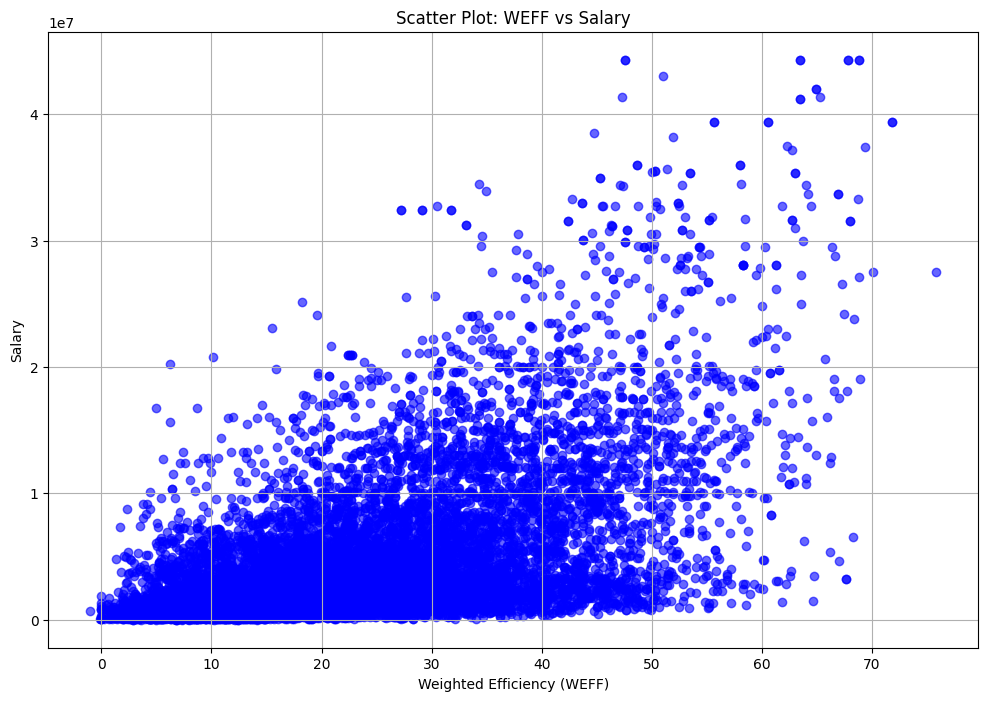

In [16]:
# Scatter Plot: Weighted Efficiency (WEFF) vs Salary
plt.figure(figsize=(12, 8))
plt.scatter(df['WEFF'], df['salary'], alpha=0.6, color='blue')
plt.title('Scatter Plot: WEFF vs Salary')
plt.xlabel('Weighted Efficiency (WEFF)')
plt.ylabel('Salary')
plt.grid(True)
plt.show()


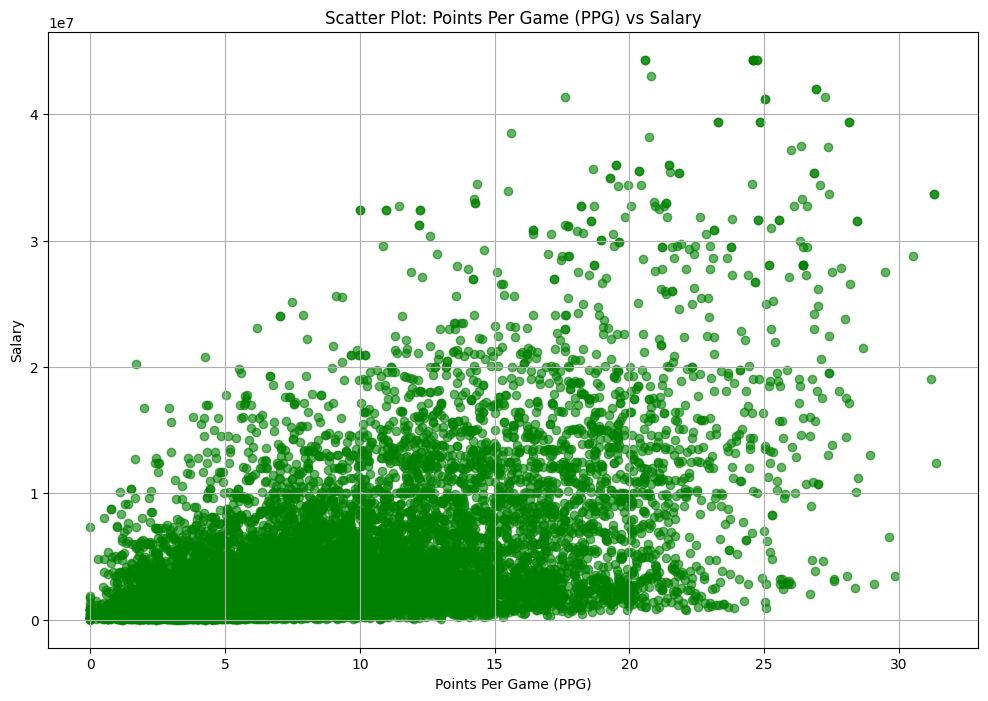

In [17]:
# Scatter Plot: Points Per Game (PPG) vs Salary
df['PPG'] = (df['PTS'] / df['G']).fillna(0).round(2)
plt.figure(figsize=(12, 8))
plt.scatter(df['PPG'], df['salary'], alpha=0.6, color='green')
plt.title('Scatter Plot: Points Per Game (PPG) vs Salary')
plt.xlabel('Points Per Game (PPG)')
plt.ylabel('Salary')
plt.grid(True)
plt.show()

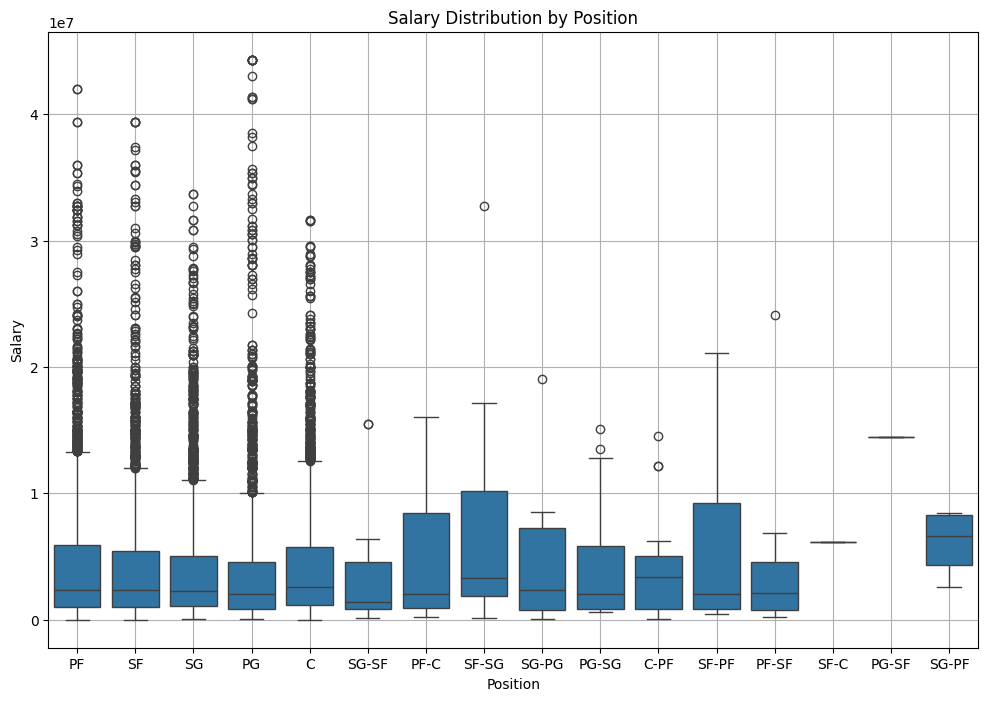

In [18]:
# Box Plot: Salary Distribution by Position
plt.figure(figsize=(12, 8))
sns.boxplot(x='Pos', y='salary', data=df)
plt.title('Salary Distribution by Position')
plt.xlabel('Position')
plt.ylabel('Salary')
plt.grid(True)
plt.show()

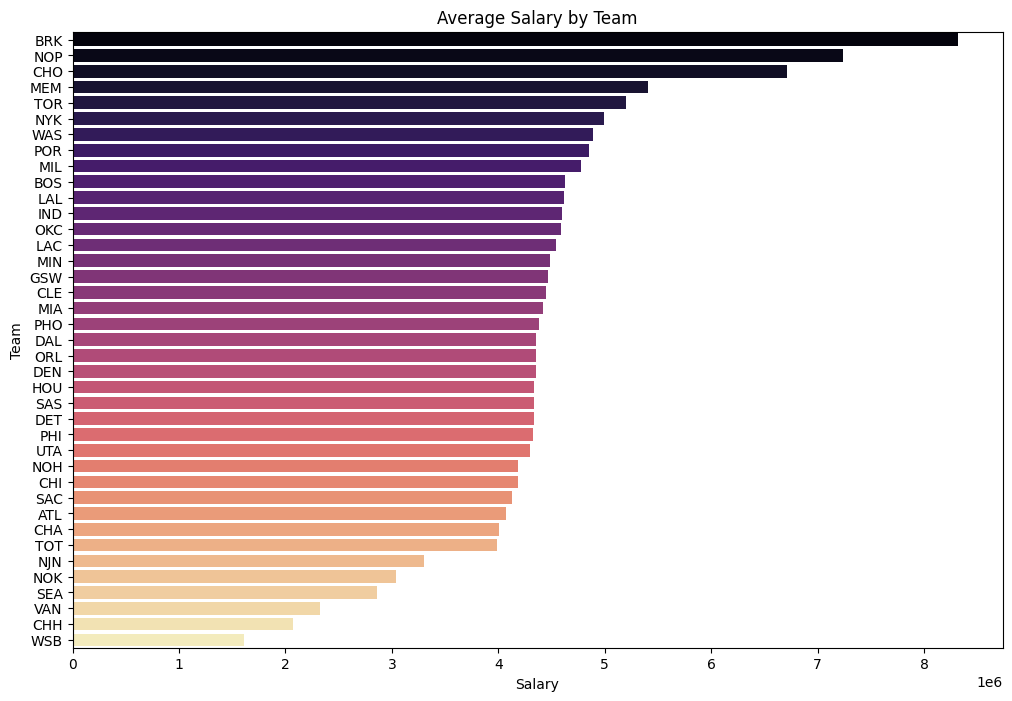

Salary Trends by WEFF Ranges:
  WEFFRange        salary       WEFF  PlayerCount
0        <0  5.620562e+05  -0.073333           15
1      0-10  1.431543e+06   6.634591         2468
2     10-20  2.473275e+06  14.901206         3998
3     20-30  4.307777e+06  24.557356         3113
4     30-40  6.807879e+06  34.476069         1984
5     40-50  9.573052e+06  44.405837         1057
6       >50  1.593894e+07  56.164969          477


In [20]:
# Bar Plot: Average Salary by Team
avg_salary_team = df.groupby('Tm')['salary'].mean().reset_index().sort_values('salary', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(y='Tm', x='salary', data=avg_salary_team, hue='Tm', dodge=False, palette='magma')
plt.title('Average Salary by Team')
plt.xlabel('Salary')
plt.ylabel('Team')
plt.show()

#For the scatterplots, there is a trend where players with higher WEFF / PPG generally tend to have higher salaries, though there’s significant variance. But alone, they arent the sole determinants
#So we will use these variables combined with other metrics like WEFF, PPG, RPG, and team to create a multivariate model

# Salary distribution by position highlights which positions tend to earn higher median salaries. Even with variation, certain non-hybrid positions (e.g., PG, C) have more high-salary outliers beyond the third quartile,
#indicating that these roles tend to have elite players earning significantly more than the median.

# Average salary by team shows how different teams have different standards when assigning salaries. So, including Team as a categorical variable in the prediction model can provide valuable information.

# Explore aggregated insights into how salary trends vary by WEFF ranges

# Divide WEFF into meaningful ranges
# 给WEFF 分组.
df['WEFFRange'] = pd.cut(df['WEFF'], bins=[-10, 0, 10, 20, 30, 40, 50, 100],
                         labels=['<0', '0-10', '10-20', '20-30', '30-40', '40-50', '>50'])

# Group data by WEFFRange and calculate aggregated statistics
# 根据weff的区间来判断球员薪水平均值 weff平均值 以及球员数量 最后搞一个df出来.
weff_salary_analysis = df.groupby('WEFFRange', observed=False, as_index=False).agg({'salary': 'mean', 'WEFF': 'mean', 'Player': 'count'})
weff_salary_analysis.rename(columns={'Player': 'PlayerCount'}, inplace=True)
print("Salary Trends by WEFF Ranges:")
print(weff_salary_analysis)


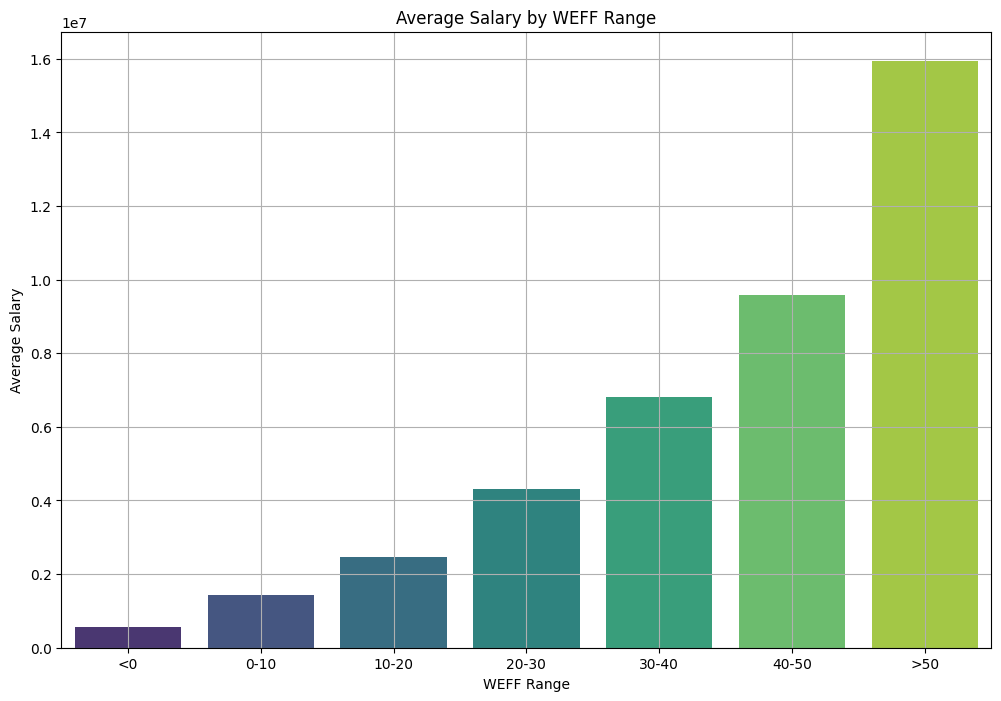

In [21]:
# Visualize Average Salary by WEFF Range
plt.figure(figsize=(12, 8))
sns.barplot(x='WEFFRange', y='salary', hue='WEFFRange', dodge=False, data=weff_salary_analysis, palette='viridis', legend=False)
plt.title('Average Salary by WEFF Range')
plt.xlabel('WEFF Range')
plt.ylabel('Average Salary')
plt.grid(True)
plt.show()

In [22]:

# - The visualization shows that as WEFF (Weighted Efficiency) increases, the average salary also increases significantly.
# - Players with WEFF in the highest range (>50) earn the highest average salary (~$12 million), confirming that elite performance levels are highly valued in terms of salary.
# - Most players fall within the 0-10 and 10-20 WEFF ranges, indicating that mid-range efficiency is the norm for most players.
# - The visualization highlights how salary progressively scales with WEFF, with noticeable jumps between ranges, especially in the higher efficiency ranges (30-40, 40-50, >50).

# - This means categorizing WEFF into ranges can provide additional insights into player value and performance tiers

df.columns

Index(['Season', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'playerName', 'seasonStartYear', 'salary', 'WEFF', 'PPG', 'APG', 'RPG',
       'SPG', 'BPG', 'TPG', 'UsageRate', 'ShootingEfficiency',
       'OffensiveContribution', 'DefensiveContribution', 'Experience', 'GS%',
       'ImpactScore', 'MPG', 'WEFFRange'],
      dtype='object')

<div class="alert alert-block alert-info">
    <h2>First Linear Regression</h2>
</div>


In [23]:
# INITIAL MODEL:

# Select relevant features for salary prediction
# The features below include both raw metrics and engineered features
features = [
    'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TOV', 'FGA', 'FG', 'FTA', 'FT',
    'G', 'GS', 'MP', 'WEFF', 'PPG', 'APG', 'RPG', 'SPG', 'BPG', 'TPG',
    'UsageRate', 'ShootingEfficiency', 'OffensiveContribution', 'DefensiveContribution',
    'Age', 'Experience', 'GS%', 'ImpactScore', 'Pos', 'PF', 'ORB', '3PA', '3P%',
    '2PA', '2P%', 'FT%', 'DRB', '2P'
]

target = 'salary'

X = df[features]
y = df[target]

# Encode categorical variable ('Pos') using one-hot encoding
# 因为线性回归和大多数ML算法只能处理数值输入 不能处理分类特征
all_categories = df['Pos'].unique()  # Get all unique categories of 'Pos'

# Preprocessor encodes 'Pos' (player position) while leaving other numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(categories=[all_categories], handle_unknown='ignore', drop='first'), ['Pos'])
    ],
    remainder='passthrough'
)
# 用百分之80的数据训练 用百分之20的数据来测试这百分之80
# Splits the data into training and testing sets to evaluate model performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#
# Create a Pipeline with Preprocessing and Linear Regression
# Combines preprocessing (one-hot encoding) and the linear regression model in a single pipeline
# 将预处理和回归合在一起.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fits the pipeline to the training data
#x_train 和y_train 应该分别是什么？ y是salary
# 在训练阶段是fit
model_pipeline.fit(X_train, y_train)

# Predicts salaries on the test set and evaluates the model using MSE and R-squared
# 为什么这里是predict 而且只有一个参数 前面是call fit 且有两个参数>
# 学习完了以后才是predict 所以只需要特征集就可以
y_pred = model_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Model Performance:
Mean Squared Error (MSE): 11951930934673.18
R-squared (R²): 0.60


<div class="alert alert-block alert-info">
    <h2>Diagonal For The First linear Regression</h2>
</div>


In [24]:
# Resulted in low R^2 --> a simple regression model does not capture the complex and maybe non-linear relationships between features and salary

# 以下部分是对上面的线性回归做一个诊断性统计分析 来看看模型的预测能力和拟合质量 以及是否存在欠拟合 多共线的情况
# 诊断用statsmodels里的least square 原因是会给出刚刚线性回归回归系数的标准误差 t 值 p 值 置信区间 VIF等 方便诊断
# Ensure X and y are properly cleaned and aligned
X = X_train.copy()  # Replace with feature matrix
y = y_train.copy()  # Replace with target variable

# Keep only numeric columns in X
X = X.select_dtypes(include=[np.number])

# Ensure y is numeric and aligned with X
y = pd.to_numeric(y, errors='coerce')
# 以防万一 因为回归的时候有出现NaN 做的处理
X = X.dropna()  # Drop rows with missing values in X
# 因为可能会删掉部分x行 所以需要对其x和y
y = y.loc[X.index]  # Align y to match X

# Add a constant column for the intercept
# 因为least square 不会自动有截距 所以这里放一个X 代表了全1的列.
X = sm.add_constant(X)
#
# Check for duplicate column names and fix if needed
# 消除可能重复的列名
X = X.loc[:, ~X.columns.duplicated()]
#
# Fit the regression model 最小二乘其实就是吧线性回归模型中得到最好的系数的一个方法. 让预测值和实际值最小
# model会得到最优的系数 以及最优的预测值 以及残差 还有各种统计量
model = sm.OLS(y, X).fit()

# Calculate the Hat matrix
# 最优y = Hy. H矩阵中的每一个元素hii 会衡量第i个样本在回归中对最优系数的印象里. 也就是说如果hii越大
# 证明这个样本在回归中的比重越大. 更容易成为outliers. 可以结合ri 和hii. 计算press 标准化残差等
X_np = X.to_numpy()  # Convert to numpy for compatibility
hat_matrix = X_np @ np.linalg.inv(X_np.T @ X_np) @ X_np.T

# Compute residuals
residuals = y - model.fittedvalues

# Calculate PRESS
# It calculates in same way in R: SUM of ( ( residuals / (1 - hat values)) ^2 )
# 衡量模型预测能力的统计量. 对每一个样本做一次留一预测 得到的残差 然后的平方和.
press_residuals = residuals / (1 - np.diag(hat_matrix))
# 如果值越小证明预测能力更好. 常用于模型比较和选择 通常选择press 最低的那个
press = np.sum(press_residuals**2)

# Calculate Cp 所以Cp的核心是选择最优的变量features
# p = 特征数+截距数 如果Cp 约等于 p 那么模型不包含过多重复的变量也没有遗漏的
# 如果Cp >= p 代表欠拟合 还需要加一些重要特征
# 如果Cp <= p 代表过拟合了 需要筛掉一些特征

sigma_squared = np.sum(residuals**2) / (len(y) - int(model.df_model) - 1)

cp = np.sum(residuals**2) / sigma_squared - len(y) + 2 * int(model.df_model)

# Output results
print(f"PRESS: {press}, Cp: {cp}")

#PRESS measures how well your model predicts unseen data ; this have a high value so we aim to create a better and more complex model
Cp = 30
# Mallows' Cp compares the quality of the model to a theoretical "perfect" model. A good model has Cp ≈ p, where p is the number of predictor


p = X.shape[1]  # Number of columns in X represents the number of predictors, including the intercept

print(f"Number of predictors (p): {p}")

# In this case, Cp < p --> This means that the model may be overfitting and too many important predictors & there might be multicollinearity in model
# To address all this, we want to only use variables that show some pattern and are relevant to not miss any predictors and also not have multicollinearity


PRESS: 1.3256581982539723e+17, Cp: 30.0
Number of predictors (p): 38


<div class="alert alert-block alert-info">
    <h2>Visualize the realtionship between numerical features and salary to get ride of some features</h2>
</div>


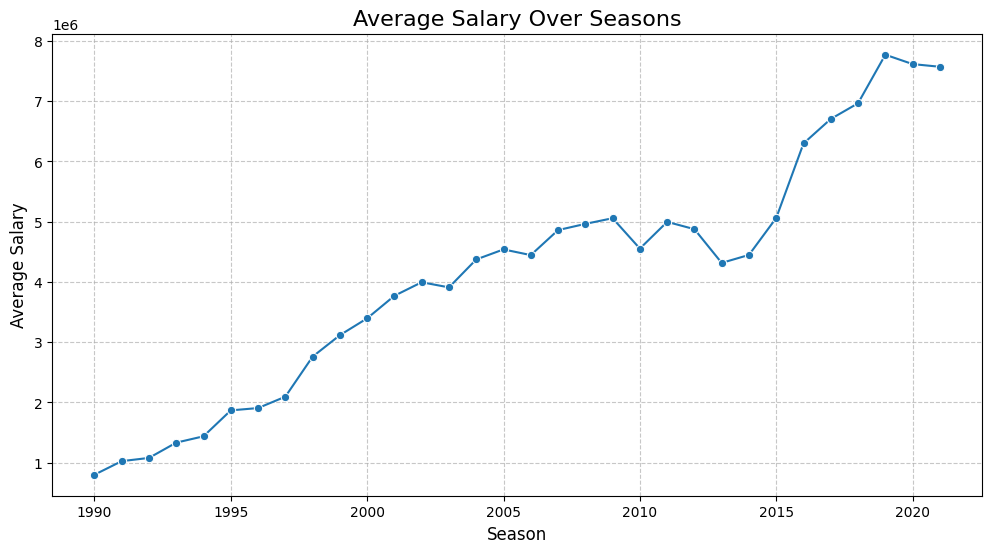

In [25]:
# Create more visualizations to find meaningful features and patterns for predicting salary
# Average Salary Over Time
# 对薪资随时间变化的关系.  按照赛季分组. 得到每个赛季的平均薪水
avg_salary_by_season = df.groupby('Season')['salary'].mean()

# Line Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_salary_by_season.index, y=avg_salary_by_season.values, marker='o')
plt.title('Average Salary Over Seasons', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# This plot shows the trend of average NBA player salaries over seasons.
# - Salaries steadily increased from 1990 to 2015, reflecting the NBA's growing revenue and popularity.
# - Around 2014, there was a period of stagnation in salary growth, likely due to the salary cap constraints before the massive TV rights deal signed in 2014 (effective in 2016).
# - A sharp spike in 2016 corresponds to the new TV rights deal, which significantly increased the salary cap.
# - Post-2020, salaries show slight stagnation or decline, likely influenced by the financial impacts of the COVID-19 pandemic.
# This highlights how external factors, such as league revenue and salary cap adjustments, directly impact player salaries.
# So, season is important factor in predicting salary

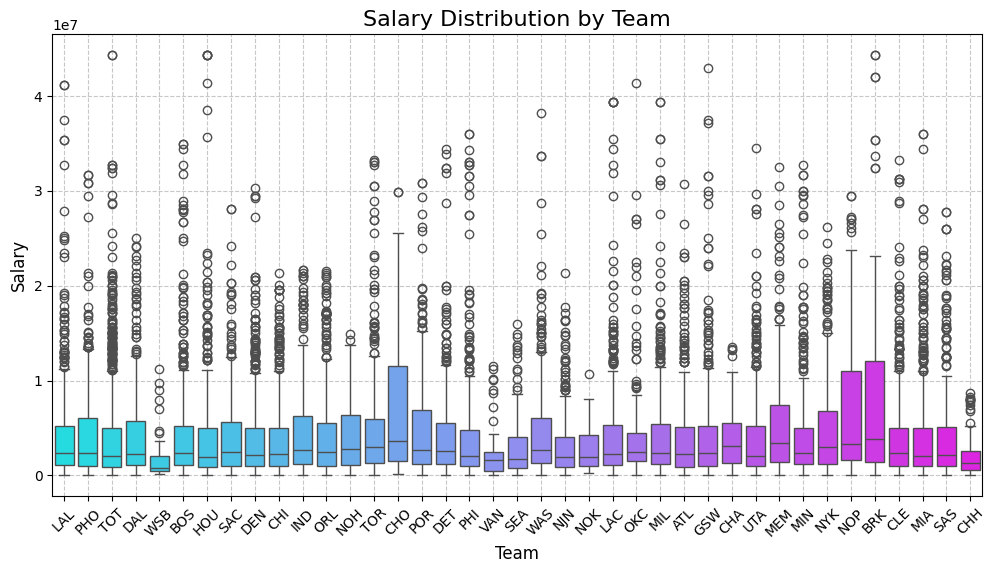

In [26]:
# Box Plot: Salary by Team # 这里又开始对Team和Salary之间的关系做可视化
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Tm', y='salary', palette='cool', hue='Tm')
plt.title('Salary Distribution by Team', fontsize=16)
plt.xlabel('Team', fontsize=12)
plt.ylabel('Salary', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

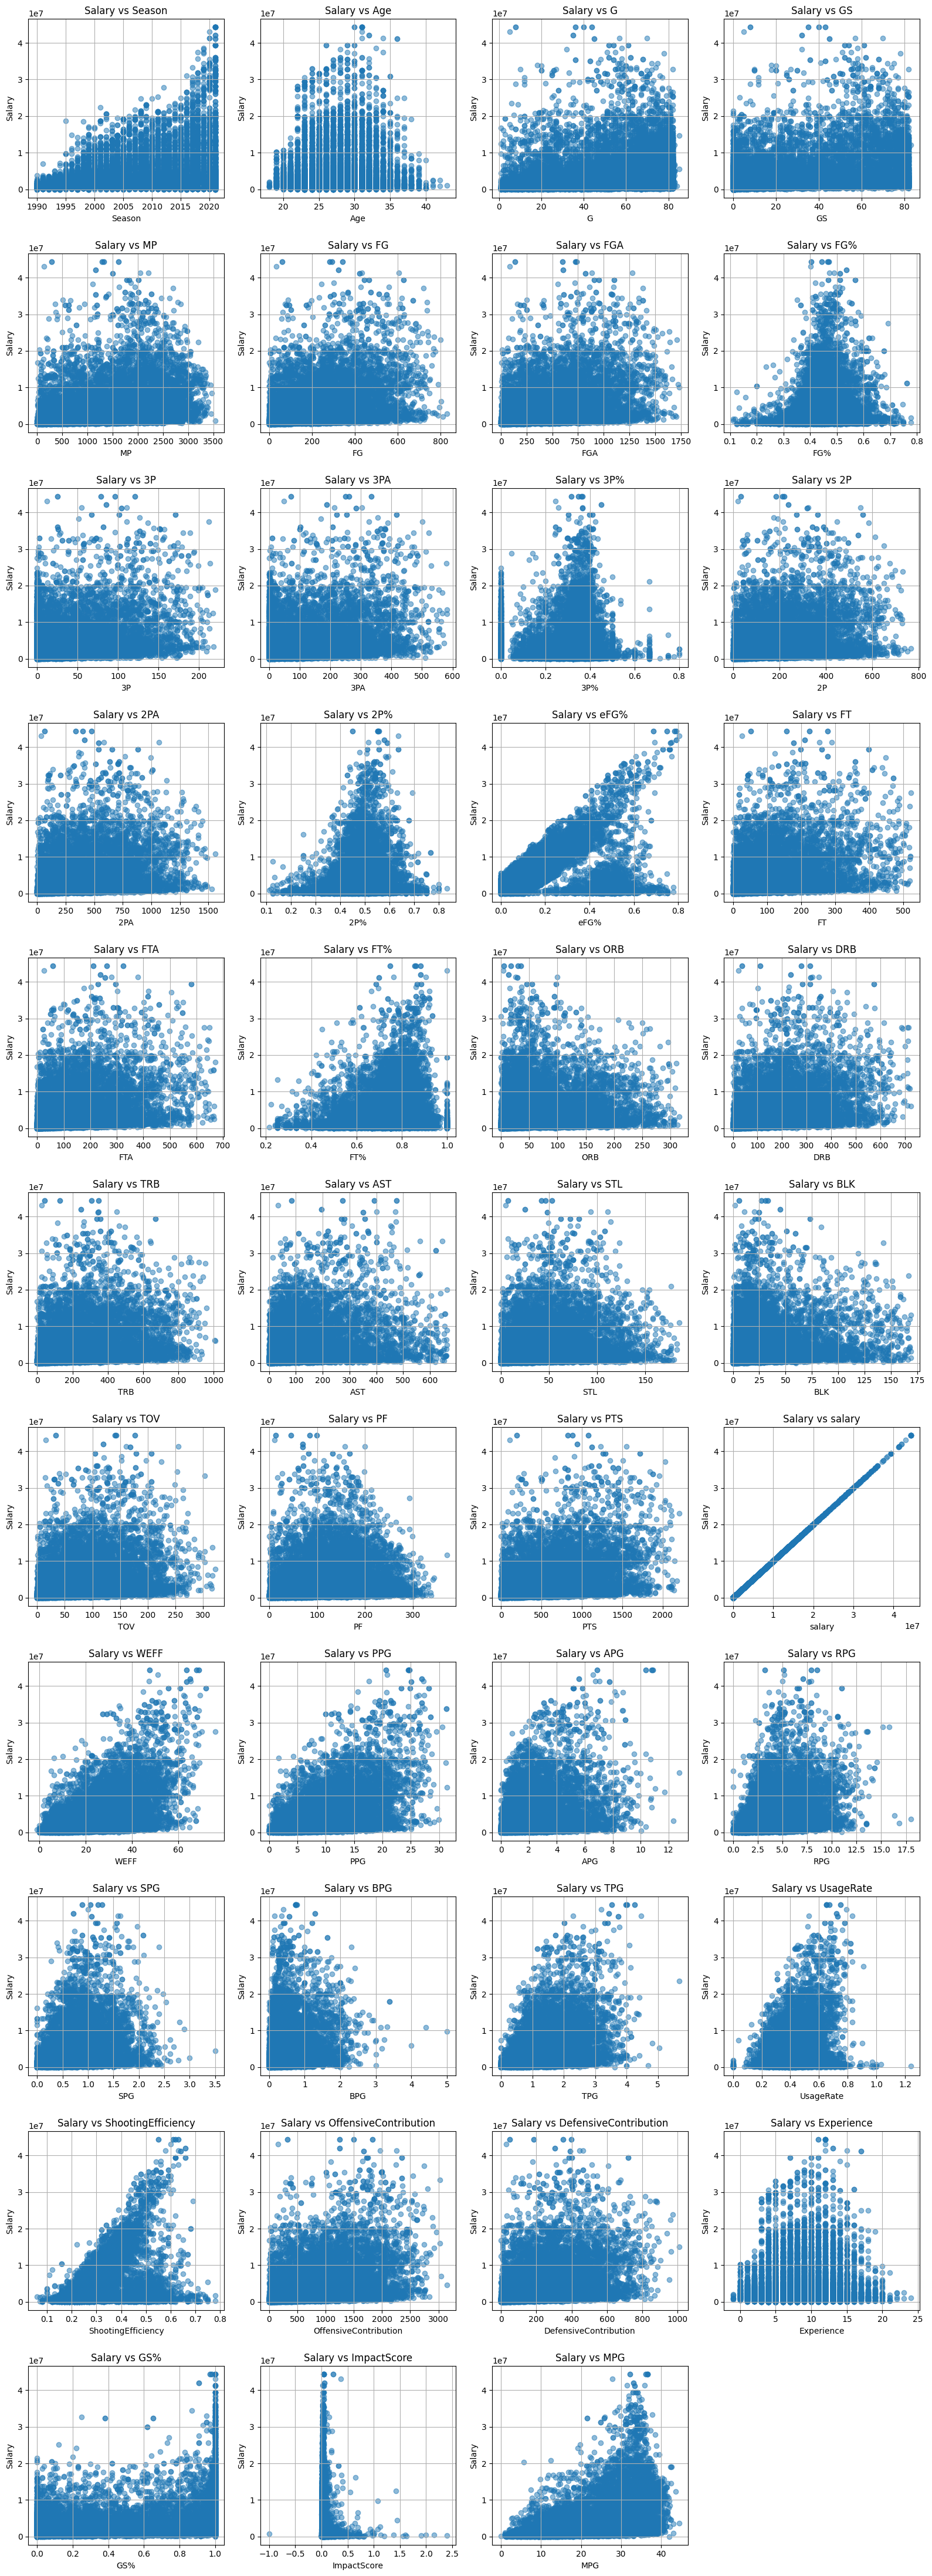

In [28]:
# This visualization helps by showing the salary distribution across different teams, highlighting variations in team spending habits.
# It reveals which teams have more consistent salary structures versus those with large disparities, likely due to a few superstar contracts.
# This insight emphasizes the importance of including the team (Tm) as a feature in the salary prediction model, as team-level factors significantly influence player salaries.

# For example, BRK (Brooklyn Nets) shows large disparities in salary distribution, with a wide IQR, indicating significant salary for superstar players.

#Scatterplots for all the metrics vs salary --> show the plots again
# 将每一个数值特征拿过来和薪水做可视化 看看哪些特征高度相关哪些特征不相关可以删除

int_columns = ['Season', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
 'salary', 'WEFF', 'PPG', 'APG', 'RPG', 'SPG', 'BPG', 'TPG', 'UsageRate', 'ShootingEfficiency',
 'OffensiveContribution', 'DefensiveContribution', 'Experience', 'GS%', 'ImpactScore', 'MPG']

plots_per_row = 4
total_plots = len(int_columns)
rows = (total_plots // plots_per_row) + (total_plots % plots_per_row > 0)

fig, axes = plt.subplots(rows, plots_per_row, figsize=(16, rows * 4))
axes = axes.flatten()

for idx, column in enumerate(int_columns):
    axes[idx].scatter(df[column], df['salary'], alpha=0.5)
    axes[idx].set_title(f'Salary vs {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Salary')
    axes[idx].grid(True)
for ax in axes[total_plots:]:
    ax.axis('off')
plt.tight_layout()
plt.show()


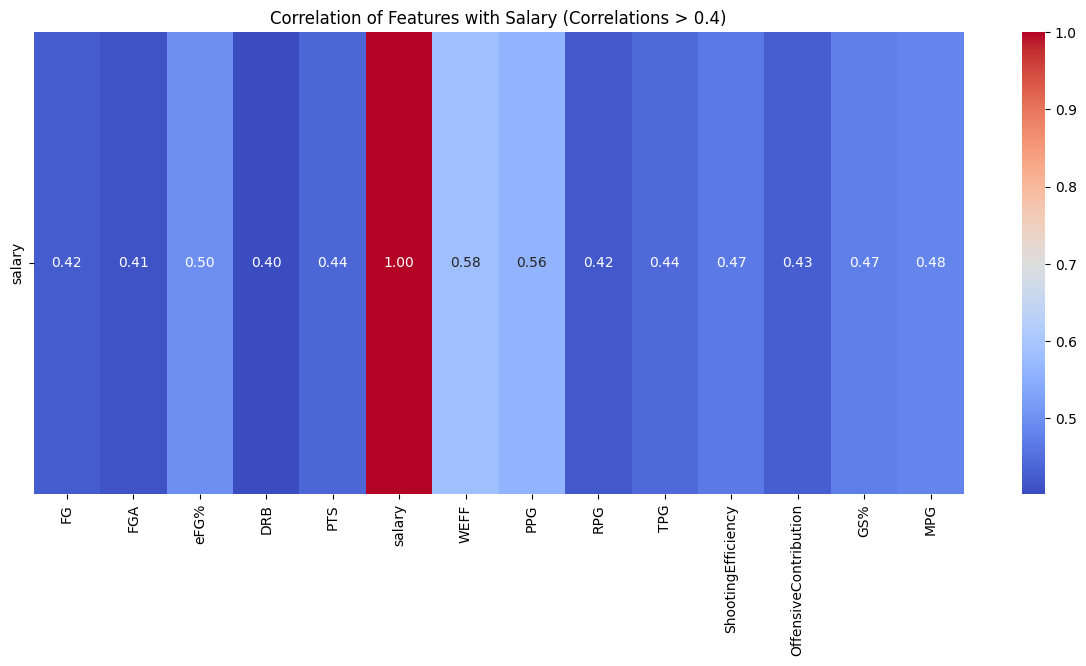

In [30]:
#heatmap that visually represents the correlation between the important selected features from above and salary
# 热力图使用颜色深浅来直观表示数值大小或强弱关系的二位图标. 如果颜色很深则表示数值之间高度相关 可能会有共线性.
# 也可以看出来哪些特征对于目标变量很关键 或不关键

columns_of_interest = ['Season', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
                       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
                       'salary', 'WEFF', 'PPG', 'APG', 'RPG', 'SPG', 'BPG', 'TPG', 'UsageRate', 'ShootingEfficiency',
                       'OffensiveContribution', 'DefensiveContribution', 'Experience', 'GS%', 'ImpactScore', 'MPG']

correlation_matrix = df[columns_of_interest].corr()

# Find correlations greater than 0.4 of features with salary
salary_correlation = correlation_matrix['salary'][correlation_matrix['salary'] > 0.4]

salary_correlation_df = salary_correlation.to_frame().T

# Plot the heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(salary_correlation_df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation of Features with Salary (Correlations > 0.4)")
plt.show()

# We see these features have relatively useful correlation with salary: 'GS', 'FG', 'FGA', 'eFG%', 'DRB', 'PTS', 'WEFF', 'PPG', 'RPG', 'TPG', 'ShootingEfficiency', 'OffensiveContribution','DefensiveContribution', 'GS%', 'MPG'
# This relates to the plots we did before too ; so we will include these in overall model

<div class="alert alert-block alert-info">
    <h2>Second Time Linear Regression</h2>
</div>


In [31]:
# Define the target variable and features (the ones we found were good from the plots, correlation, and sql queries)
# 重新做一次linear regression 这次挑出了一些最具有价值的特征做回归. 跳出了最强的17个特征
selected_columns = [
    'Season', 'Tm', 'Age', 'GS', 'FG', 'FGA', 'eFG%',
    'WEFF', 'PPG', 'RPG', 'TPG', 'APG',
    'ShootingEfficiency', 'OffensiveContribution',
    'DefensiveContribution', 'GS%', 'MPG'
]
X = df[selected_columns]  # Use only the specified columns for features
y = df['salary']  # Use Salary as the target

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
#
# Define transformations for each column type
# 重新再做一次onehot 因为之前第一次做linear regression虽然也做了 但只是临时的
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale numerical columns
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#linear Regression Model


# Create a pipeline with Linear Regression
linear_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
linear_reg_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = linear_reg_pipeline.predict(X_test)

# Evaluation
print("Linear Regression Results")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R² score:", r2_score(y_test, y_pred))



Linear Regression Results
Mean Absolute Error (MAE): 2427127.831162179
Mean Squared Error (MSE): 10571180416931.594
R² score: 0.6467959183492429



Query 1: Average Salary by Age Group
     Age    avg_salary
0   18.0  1.231681e+06
1   19.0  3.102774e+06
2   20.0  2.781668e+06
3   21.0  2.510537e+06
4   22.0  2.620775e+06
5   23.0  2.937011e+06
6   24.0  3.399346e+06
7   25.0  4.018313e+06
8   26.0  5.227425e+06
9   27.0  5.031670e+06
10  28.0  5.566513e+06
11  29.0  5.871611e+06
12  30.0  5.872135e+06
13  31.0  6.190375e+06
14  32.0  5.914632e+06
15  33.0  5.270169e+06
16  34.0  5.015240e+06
17  35.0  4.426321e+06
18  36.0  4.399922e+06
19  37.0  3.342622e+06
20  38.0  2.889568e+06
21  39.0  2.853830e+06
22  40.0  1.723074e+06
23  41.0  1.747094e+06
24  42.0  1.782376e+06
25  43.0  1.150000e+06

Query 2: Correlation Between Salary and Points Per Game (PPG)
        PPG    avg_salary
0     31.38  1.237500e+07
1     31.30  3.372420e+07
2     31.20  1.901250e+07
3     30.54  2.875177e+07
4     29.87  3.500000e+06
...     ...           ...
2265   0.29  2.900000e+06
2266   0.25  3.109080e+05
2267   0.22  2.500000e+04
2268   0.20  1.320

Index(['Season', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'playerName', 'seasonStartYear', 'salary', 'WEFF', 'PPG', 'APG', 'RPG',
       'SPG', 'BPG', 'TPG', 'UsageRate', 'ShootingEfficiency',
       'OffensiveContribution', 'DefensiveContribution', 'Experience', 'GS%',
       'ImpactScore', 'MPG', 'WEFFRange'],
      dtype='object')

Linear Regression Results
Mean Absolute Error (MAE): 2427127.8311621808
Mean Squared Error (MSE): 10571180416931.594
R² score: 0.6467959183492429


Decision Tree Results
Mean Absolute Error (MAE): 1640959.0289744567
Mean Squared Error (MSE): 7188092715569.967
R² score: 0.7598315811205953


Trial 1: Loss = 5.338999009150912e+17
Trial 2: Loss = 5.338998513716873e+17
Trial 3: Loss = 5.3389995828259034e+17
Trial 4: Loss = 5.338998475592686e+17
Trial 5: Loss = 5.3389992911243334e+17
Trial 6: Loss = 5.3389993424081056e+17
Trial 7: Loss = 5.3389987667572314e+17
Trial 8: Loss = 5.338998681865705e+17
Trial 9: Loss = 5.339000299300733e+17
Trial 10: Loss = 5.339000496965682e+17
Trial 11: Loss = 5.338999516815476e+17
Trial 12: Loss = 5.338997871948916e+17
Trial 13: Loss = 5.338998260559515e+17
Trial 14: Loss = 5.339000638443617e+17
Trial 15: Loss = 5.338999053627322e+17
Test MSE: 50338332714150.27
Test R²: 0.681903427705614


Random Forest Results
Mean Absolute Error (MAE): 1259028.0695768204
Mean Squared Error (MSE): 3778805494976.6465
R² score: 0.8737426217367057


Cross-Validation R² Scores: [0.90212357 0.88023246 0.87357296 0.87173188 0.86478244 0.86447669
 0.89991144 0.87973249 0.86352734 0.85883775]
Mean R²: 0.8758929033675343, Std: 0.014208328460284839


                            min       max
Season                 1990.000  2021.000
Age                      18.000    43.000
GS                        0.000    83.000
FG                        0.000   830.000
FGA                       0.000  1724.000
eFG%                      0.001     0.803
WEFF                     -1.000    71.870
PPG                       0.000    31.380
RPG                       0.000    16.330
TPG                       0.000     5.670
APG                       0.000    12.750
ShootingEfficiency        0.060     0.780
OffensiveContribution     0.000  3041.500
DefensiveContribution     0.000   973.000
GS%                       0.000     1.000
MPG                       0.000    43.700


Available columns in df: ['Season', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'playerName', 'seasonStartYear', 'salary', 'WEFF', 'PPG', 'APG', 'RPG', 'SPG', 'BPG', 'TPG', 'UsageRate', 'ShootingEfficiency', 'OffensiveContribution', 'DefensiveContribution', 'Experience', 'GS%', 'ImpactScore', 'MPG', 'WEFFRange']
All selected columns are present!


Epoch 1/100


c:\Users\vedp2\OneDrive\Desktop\nbaModel\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 49342450761728.0000 - mae: 4282519.5000 - val_loss: 50318079426560.0000 - val_mae: 4516334.0000
Epoch 2/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 51030586818560.0000 - mae: 4376516.5000 - val_loss: 50170934853632.0000 - val_mae: 4507091.5000
Epoch 3/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 50293752463360.0000 - mae: 4378137.5000 - val_loss: 49794097610752.0000 - val_mae: 4483439.5000
Epoch 4/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 51441561501696.0000 - mae: 4412857.0000 - val_loss: 49141321302016.0000 - val_mae: 4442217.0000
Epoch 5/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 50090098032640.0000 - mae: 4338671.0000 - val_loss: 48168729313280.0000 - val_mae: 4380450.0000
Epoch 6/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 47684807294976.0000 - mae: 4209887.5000 - val_loss: 46868641873920.0000 - val_mae: 4297082.5000
Epoch 7/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 460455977

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
R² score of the TensorFlow model: 0.7123


Model saved as nba_salary_rf_model.pkl


Unique Teams:
['LAL' 'PHO' 'TOT' 'DAL' 'WSB' 'BOS' 'HOU' 'SAC' 'DEN' 'CHI' 'IND' 'ORL'
 'NOH' 'TOR' 'CHO' 'POR' 'DET' 'PHI' 'VAN' 'SEA' 'WAS' 'NJN' 'NOK' 'LAC'
 'OKC' 'MIL' 'ATL' 'GSW' 'CHA' 'UTA' 'MEM' 'MIN' 'NYK' 'NOP' 'BRK' 'CLE'
 'MIA' 'SAS' 'CHH']

Columns used for training the Random Forest model:
['Season', 'Tm', 'Age', 'GS', 'FG', 'FGA', 'eFG%', 'WEFF', 'PPG', 'RPG', 'TPG', 'APG', 'ShootingEfficiency', 'OffensiveContribution', 'DefensiveContribution', 'GS%', 'MPG']
